[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/open-atmos/PyPartMC/blob/main/examples/additive_coag_comparison.ipynb)   
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyPartMC/blob/main/examples/additive_coag_comparison.ipynb)    
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyPartMC.git/main?urlpath=lab/tree/examples/additive_coag_comparison.ipynb)

In [1]:
# This file is a part of PyPartMC licensed under the GNU General Public License v3
# Copyright (C) 2025 University of Illinois Urbana-Champaign
#
# PartMC Authors:
#  - https://github.com/compdyn/partmc/graphs/contributors
#  - https://github.com/open-atmos/PyPartMC/graphs/contributors

In [2]:
# pylint: disable=too-few-public-methods, import-outside-toplevel, missing-class-docstring


This notebook aims to compare the results of three stochastic particle-based models using a coagulation only box model test case.
The models (PyPartMC, PySDM, and Droplets.jl) model the evolution of the droplet size distribution using the Golovin (additive) collision kernel [Golovin 1963](http://mi.mathnet.ru/dan27630). We have chosen this kernel because it has an analytical solution, also included in this notebook.
These settings reproduce Figure 2a in section 5.1.4 of [Shima et al. 2009](https://DOI.org/10.1002/qj.441) as a "Hello World" for droplet collisional growth.
[PySDM](https://open-atmos.github.io/PySDM/) and [Droplets.jl](https://github.com/emmacware/droplets.jl) use the Shima et al. 2009 coagulation scheme (Super-Droplet Method or SDM), and PyPartMC uses the Weighted Flow Algorithm (WFA) for droplet coagulation [DeVille et al. 2011](https://DOI.org/10.1016/j.jcp.2011.07.027) 

Another goal of this notebook is to provide a framework for additional model comparisons. The structure of the workflow in this notebook was created with this in mind. The model subclasses within the run class standardize the format of the common input and output, creating a format for new models to follow. Although all models represented currently are particle-based models, the format and settings should be generalizable to any method that handles coagulation growth of cloud droplets. An example workflow for models different languages is also included in the notebook with Droplets.jl, a native Julia model.

In [3]:
import sys
import shutil

if "google.colab" in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyPartMC', 'PySDM')
    
    # install julia if not in system
    if shutil.which('julia') is None:
        !wget -q https://julialang-s3.julialang.org/bin/linux/x64/1.11/julia-1.11.3-linux-x86_64.tar.gz -O /tmp/julia.tar.gz; \
        tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1; \
        rm /tmp/julia.tar.gz;

In [4]:
from collections import namedtuple
from functools import partial
import urllib
import json
import subprocess
import warnings
import numpy as np
import matplotlib.pyplot as plt
from open_atmos_jupyter_utils.show_anim import show_anim 
# note: model-related imports have been moved to the specific model class cells

In [5]:
SETTINGS = {
    # Physical parameters
    'N_PART': 2**16,
    'VOLUME_M3': 1e6,
    'DT_SEC': 1.,
    'NUM_CONC_PER_M3': 2**23,
    'DIAM_AT_MEAN_VOL_M': 2*30.531e-6,
    'ADDITIVE_KERNEL_COEFF': 1500,
    
    # Plotting parameters
    'T_MAX_SEC': 3600,
    'PLOT_TIME_STEP_SEC': 120,
    'RADIUS_BIN_EDGES_M': list(np.logspace(np.log10(1e-5), np.log10(5e-3), num=129, endpoint=True))
}

# Derived parameters
SETTINGS['N_BINS'] = len(SETTINGS["RADIUS_BIN_EDGES_M"]) - 1
SETTINGS["N_PLOT_STEPS"] = SETTINGS["T_MAX_SEC"] // SETTINGS["PLOT_TIME_STEP_SEC"]
assert SETTINGS["N_PLOT_STEPS"] * SETTINGS["PLOT_TIME_STEP_SEC"] == SETTINGS["T_MAX_SEC"]

# Save settings into json file for julia process
with open('setup.json', 'w', encoding='UTF-8') as f:
    json.dump(SETTINGS, f)

SETTINGS['RADIUS_BIN_EDGES_M'] = np.array(SETTINGS['RADIUS_BIN_EDGES_M'])
SETTINGS = namedtuple("Settings", SETTINGS.keys())(**SETTINGS)  # ensure immutable

# Every model is set up to be a subclass of the Run class
class Run:
    def __init__(self, settings):
        print(f"Instantiating {self.__class__.__name__}")
        self.settings = settings

### Format for a new model run, search NEW_MODEL for lines to change

In [6]:
# pylint: disable=unnecessary-pass
class NewModelRun(Run):
    def __init__(self,settings):
        super().__init__(settings)
        # Import model packages here instead of at the top of the notebook
        # import newmodel as nm

        # use the settings dictionary to set up the model parameters
        self.settings = settings
        self.bin_data = np.full(self.settings.N_BINS, fill_value=np.nan)

    def __call__(self):
        # Run the model here
        # Output should be a dictionary with the following spectra:
        out = {'Number Concentration (#/m^3/unit ln R)':{}, 'Mass Density (kg/m^3/unit ln R)':{}}

        # Use the settings dictionary to output common results        
        pass

        # Example run
        for step in range(self.settings.N_PLOT_STEPS+1):
            if step != 0:
                # Run model until next output time (step)
                pass

            # Calculate and save mass density and number concentration
            mass_density = self.bin_data.copy() #kilograms of water per m^3 per dlnr
            pass
            out['Mass Density (kg/m^3/unit ln R)'][step] = mass_density

            number_density = self.bin_data.copy() #number of water droplets per m^3
            pass
            out['Number Concentration (#/m^3/unit ln R)'][step] = number_density

        return out

In [7]:
class AnalyticalSoln(Run):
    """
    Analytical solution for the Golovin kernel taken from PySDM 
    """
    def __init__(self, settings):
        super().__init__(settings)

        from PySDM import Formulae
        from PySDM.dynamics.collisions import collision_kernels 

        self.formulae = Formulae()
        volume_bins_edges = self.formulae.trivia.volume(settings.RADIUS_BIN_EDGES_M)
        dv, dr = np.diff(volume_bins_edges), np.diff(settings.RADIUS_BIN_EDGES_M)
        self.dv_over_dr = dv / dr
        pdf_v_x = volume_bins_edges[:-1] + dv / 2
        self.pdf_r_x = settings.RADIUS_BIN_EDGES_M[:-1] + dr / 2
        
        self.collision_kernel=collision_kernels.Golovin(b=settings.ADDITIVE_KERNEL_COEFF)
        self.times = np.linspace(
            start=0, stop=settings.T_MAX_SEC,
            num=settings.N_PLOT_STEPS+1
        )
        self.analytical_solution = partial(
            self.collision_kernel.analytic_solution,
            x = pdf_v_x,
            x_0= self.formulae.trivia.volume(settings.DIAM_AT_MEAN_VOL_M / 2),
            N_0=self.settings.NUM_CONC_PER_M3
        )

    def __call__(self):  
        from PySDM.physics import si

        out = {'Number Concentration (#/m^3/unit ln R)':{}, 'Mass Density (kg/m^3/unit ln R)':{}}

        for step in range(self.settings.N_PLOT_STEPS+1):
            t = step*self.settings.PLOT_TIME_STEP_SEC or 1e-10 #For 0 time

            pdf_v_y = (
                self.settings.NUM_CONC_PER_M3
                * self.settings.VOLUME_M3
                * self.analytical_solution(t=t)
            )
            pdf_r_y = pdf_v_y * self.dv_over_dr * self.pdf_r_x
            y_true_mass_density = (
                pdf_r_y
                * self.formulae.trivia.volume(radius=self.pdf_r_x)
                * self.formulae.constants.rho_w
                / self.settings.VOLUME_M3*si.metres**3
                * si.kilograms
            )
            y_true_number_density = (
                pdf_r_y
                / self.settings.VOLUME_M3*si.metres**3
            )
            out['Mass Density (kg/m^3/unit ln R)'][step] = y_true_mass_density
            out['Number Concentration (#/m^3/unit ln R)'][step] = y_true_number_density

        return out

In [8]:
class RunPySDM(Run):
    def __init__(self, settings):
        import PySDM
        from PySDM.physics import si

        builder = PySDM.Builder(
            settings.N_PART,
            backend=PySDM.backends.CPU(),
            environment=PySDM.environments.Box(
                dt=settings.DT_SEC * si.s,
                dv=settings.VOLUME_M3 * si.m**3
            )
        )
        trivia = builder.formulae.trivia
        spectrum = PySDM.initialisation.spectra.Exponential(
            norm_factor=settings.NUM_CONC_PER_M3 * settings.VOLUME_M3 / si.m**3,
            scale=trivia.volume(radius=settings.DIAM_AT_MEAN_VOL_M / 2 * si.m)
        )
        builder.add_dynamic(PySDM.dynamics.Coalescence(
            collision_kernel=PySDM.dynamics.collisions.collision_kernels.Golovin(
                b=settings.ADDITIVE_KERNEL_COEFF
            ), adaptive=False
        ))

        self.particulator = builder.build(
            attributes=builder.particulator.environment.init_attributes(
                spectral_discretisation=PySDM.initialisation.sampling.spectral_sampling.Logarithmic(
                    spectrum,
                )
            ),
            products=(
                PySDM.products.ParticleSizeSpectrumPerVolume(
                    radius_bins_edges=settings.RADIUS_BIN_EDGES_M,
                    name='Number Concentration (#/m^3/m)',
                ),
                PySDM.products.ParticleVolumeVersusRadiusLogarithmSpectrum(
                    radius_bins_edges=settings.RADIUS_BIN_EDGES_M,
                    name='Volume Density (1/ unit ln R)',
                )
            )
        )
        super().__init__(settings)

    def __call__(self):
        from PySDM.physics import si, constants_defaults

        pysdm_output = {'Number Concentration (#/m^3/unit ln R)':{},
                         'Mass Density (kg/m^3/unit ln R)':{}}
        for step in range(self.settings.N_PLOT_STEPS + 1):
            if step != 0:
                self.particulator.run(int(self.settings.PLOT_TIME_STEP_SEC // self.settings.DT_SEC))
            #next two lines convert from dr to dlnr
            pysdm_output['Number Concentration (#/m^3/unit ln R)'][step] = (
                self.particulator.products['Number Concentration (#/m^3/m)'].get() 
                * (self.settings.RADIUS_BIN_EDGES_M[1:]-self.settings.RADIUS_BIN_EDGES_M[:-1])
                / (np.log(self.settings.RADIUS_BIN_EDGES_M[1:]) 
                - np.log(self.settings.RADIUS_BIN_EDGES_M[:-1]))
            )
            pysdm_output['Mass Density (kg/m^3/unit ln R)'][step] = (
                self.particulator.products['Volume Density (1/ unit ln R)'].get()[0]
                * constants_defaults.rho_w * si.kilogram / si.metre**3
            )
        return pysdm_output

In [9]:
class RunPartMC(Run):
    def __init__(self, settings):
        import PyPartMC as ppmc
        gas_data = ppmc.GasData(("Background","NO2"))
        env_state = ppmc.EnvState(
            {
                "rel_humidity": .99,
                "latitude": 40,
                "longitude": 0,
                "altitude": 0 * ppmc.si.m,
                "start_time": 0 * ppmc.si.s,
                "start_day": 1,
            }
        )
        env_state.additive_kernel_coefficient = settings.ADDITIVE_KERNEL_COEFF
        assert env_state.additive_kernel_coefficient == settings.ADDITIVE_KERNEL_COEFF

        aero_data = ppmc.AeroData((
            {"H2O": [1000 * ppmc.si.kg / ppmc.si.m**3, 0, 18.0 * ppmc.si.g / ppmc.si.mol, 0.00]},
        ))
        self.gas_state = ppmc.GasState(gas_data)

        common = [
            {"time": [0 * ppmc.si.s]},
            {"rate": [0 / ppmc.si.s]}
        ]
        placeholder_gas = [
            *common,
            {"dist":
             [[{"placeholder": {
                "mass_frac": [{"H2O": [1]}],
                "diam_type": "geometric",
                "mode_type": "log_normal",
                "num_conc": 0 / ppmc.si.m**3,
                "geom_mean_diam": 0.02 * ppmc.si.um,
                "log10_geom_std_dev": 0.161,
            },}]]},
        ]

        scenario = ppmc.Scenario(
            gas_data,
            aero_data,
            {
                "temp_profile": [{"time": [0]}, {"temp": [300]}],
                "pressure_profile": [
                    {"time": [0]},
                    {"pressure": [100000]},
                ],
                "height_profile": [{"time": [0]}, {"height": [1000]}],
                "gas_emissions": common,
                "gas_background": common,
                "aero_emissions": placeholder_gas,
                "aero_background":placeholder_gas,
                "loss_function": "none",
            },
        )

        scenario.init_env_state(env_state, 0.0)
        aero_dist_init = ppmc.AeroDist(aero_data, [
            {
                "init1": {
                    "mass_frac": [{"H2O": [1]}],
                    "diam_type": "geometric",
                    "mode_type": "exp",
                    "num_conc": settings.NUM_CONC_PER_M3 / ppmc.si.m**3,
                    "diam_at_mean_vol": settings.DIAM_AT_MEAN_VOL_M * ppmc.si.m,
                },
            }
        ])

        run_part_opt = ppmc.RunPartOpt(
            {
                "output_prefix": 'additive',
                "do_coagulation": True,
                "coag_kernel": "additive",
                "t_max": settings.T_MAX_SEC * ppmc.si.s,
                "del_t": settings.DT_SEC * ppmc.si.s,
            }
        )

        self.aero_state = ppmc.AeroState(aero_data, settings.N_PART, "flat")
        self.aero_state.dist_sample(aero_dist_init)

        self.run_part_args = (
            scenario,
            env_state,
            aero_data,
            self.aero_state,
            gas_data,
            self.gas_state,
            run_part_opt,
            ppmc.CampCore(),
            ppmc.Photolysis(),
        )
        self.rad_grid = ppmc.BinGrid(
            len(settings.RADIUS_BIN_EDGES_M) - 1,
            "log",
            settings.RADIUS_BIN_EDGES_M[0],
            settings.RADIUS_BIN_EDGES_M[-1]
        )
        super().__init__(settings)
            
    def __call__(self):
        import PyPartMC as ppmc

        dists = []
        diameters = self.aero_state.diameters()
        num_concs = self.aero_state.num_concs
        masses = self.aero_state.masses()
        mass_concs = np.array(num_concs) * np.array(masses)
        dists_mass = []
        dists.append(ppmc.histogram_1d(self.rad_grid, np.array(diameters)/2, num_concs))
        dists_mass.append(
            ppmc.histogram_1d(self.rad_grid, np.array(diameters)/2, mass_concs)
        )

        last_output_time = 0.
        last_progress_time = 0.
        i_output = 1
        t_initial = 0
        for i_time in range(1, int(self.settings.T_MAX_SEC // self.settings.DT_SEC) + 1):
            (last_output_time, last_progress_time, i_output) = ppmc.run_part_timestep(
                *self.run_part_args,
                i_time,
                t_initial,
                last_output_time,
                last_progress_time,
                i_output
            )
            
            if np.mod(i_time * self.settings.DT_SEC, self.settings.PLOT_TIME_STEP_SEC) == 0:
                diameters = self.aero_state.diameters()
                num_concs = self.aero_state.num_concs
                masses = self.aero_state.masses()
                mass_concs = np.array(num_concs) * np.array(masses)
                dists.append(ppmc.histogram_1d(self.rad_grid, np.array(diameters)/2, num_concs))
                dists_mass.append(
                    ppmc.histogram_1d(self.rad_grid, np.array(diameters)/2, mass_concs)
                )

        return {'Number Concentration (#/m^3/unit ln R)': dists,
                 'Mass Density (kg/m^3/unit ln R)': dists_mass}

In [10]:
class RunDropletsJL(Run):
    def __init__(self, _):
        BASE_URL = (
            'https://raw.githubusercontent.com/emmacware/droplets.jl/REVISION/'
        ).replace('REVISION', 'c3b5ae4edf12c7b10dc8759639f18de1267bc52b')
        for path in (
            'src/SDfunc/constants.jl', 'src/SDfunc/binning.jl', 'src/SDfunc/coalescence.jl',
        ):
            with open('Droplets.jl-' + path.replace('/','-'), 'w', encoding='utf-8') as fout:
                with urllib.request.urlopen(BASE_URL + path) as fin:
                    fout.write(fin.read().decode('utf-8'))
                    
        code_to_write = """
        using Pkg
        Pkg.add(["Combinatorics", "Distributions", "Random", "JSON", "Interpolations"])
        using Random,Combinatorics,Distributions
        include("Droplets.jl-src-SDfunc-constants.jl")
        include("Droplets.jl-src-SDfunc-coalescence.jl")
        include("Droplets.jl-src-SDfunc-binning.jl")
        using JSON
            
        FT = Float64
        setup = JSON.parsefile("./setup.json")

        coagsetting_args = (
            Ns = Int(setup["N_PART"]),
            Δt = setup["DT_SEC"],
            ΔV = setup["VOLUME_M3"],
            golovin_kernel_coeff = FT(setup["ADDITIVE_KERNEL_COEFF"]),
            n0 = FT(setup["NUM_CONC_PER_M3"]),
            R0 = FT(setup["DIAM_AT_MEAN_VOL_M"]) / 2
        )

        runsetting_args = (
            num_bins = Int(setup["N_BINS"]),
            radius_bins_edges = setup["RADIUS_BIN_EDGES_M"],
            smooth = false,
            output_steps = collect(0:setup["PLOT_TIME_STEP_SEC"]:setup["T_MAX_SEC"]),
            scheme = none(), # Adaptive() not used
            init_method = init_logarithmic
        )

        coagsettings = coag_settings{FT}(;coagsetting_args...)
        runsettings =run_settings{FT}(;runsetting_args...,binning_method = none())
        numdens_set =run_settings{FT}(;runsetting_args...,binning_method = number_density)
        massdens_set =run_settings{FT}(;runsetting_args...,binning_method = mass_density_lnr)


        droplets = runsettings.init_method(coagsettings)
        num_dens_bin::Matrix{FT} = zeros(FT, runsettings.num_bins, length(runsettings.output_steps))
        mass_dens_bin::Matrix{FT} = zeros(FT, runsettings.num_bins, length(runsettings.output_steps))

        coag_data = coagulation_run{FT}(coagsettings.Ns)
        for i  in  1:length(runsettings.output_steps)
            if i !=1
                timestepper = (runsettings.output_steps[i]-runsettings.output_steps[i-1])/coagsettings.Δt
                for _ in 1:timestepper
                    coalescence_timestep!(Serial(),runsettings.scheme,droplets,coag_data,coagsettings)
                end
            end
            num_dens_bin[:,i] = binning_func(droplets,runsettings.output_steps[i],numdens_set,coagsettings)
            mass_dens_bin[:,i] = binning_func(droplets,runsettings.output_steps[i],massdens_set,coagsettings)
        end

        dict = Dict()
        dict["Number Concentration (#/m^3/unit ln R)"] = num_dens_bin
        dict["Mass Density (kg/m^3/unit ln R)"] = mass_dens_bin
        json_string = JSON.json(dict)

        open("output.json", "w") do file
            write(file, json_string)
        end
        """

        with open('script.jl', 'w', encoding='utf-8') as file:
            file.write(code_to_write)

        super().__init__(SETTINGS)
    
    def __call__(self):
        subprocess.run(["julia", "--quiet", "script.jl"], check=True)
        with open('output.json', 'r', encoding='utf8') as file:
            Droplets = json.load(file)
        return Droplets

### Create instances of the models with common setup

In [ ]:
models = {
    'analytical': AnalyticalSoln(SETTINGS),
    'PartMC': RunPartMC(SETTINGS),
    'PySDM': RunPySDM(SETTINGS),
    '': NewModelRun(SETTINGS) #NEW_MODEL
}
if shutil.which('julia') is not None: # pylint: disable=undefined-variable
    models['Droplets.jl'] = RunDropletsJL(SETTINGS)
else:
    warnings.warn('Julia not found, skipping Droplets.jl run')
output = {k: print(f"Running {k}...") or model() for k, model in models.items()}

### use open_atmos_jupyter_utils to create comparison animation


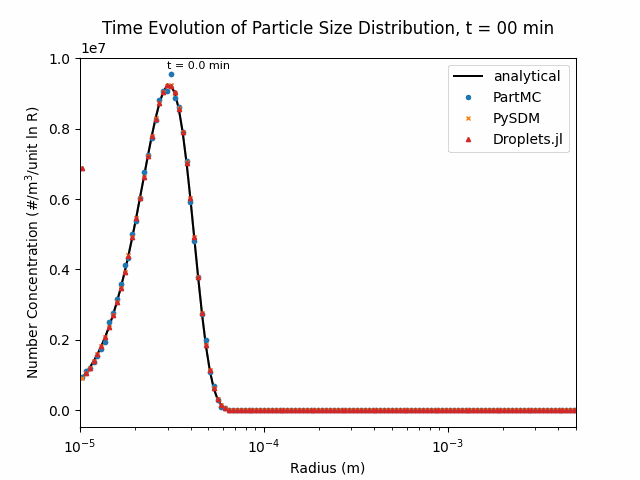

HTML(value="<a href='./tmpl0kmjlg7.gif' target='_blank'>./tmpl0kmjlg7.gif</a><br>")


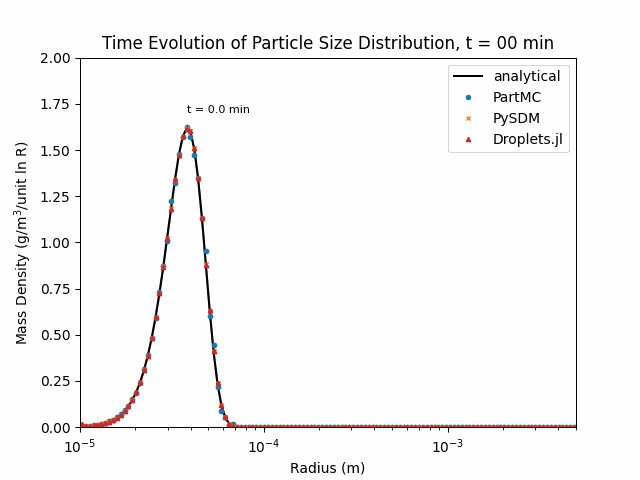

HTML(value="<a href='./tmpo_g26hgw.gif' target='_blank'>./tmpo_g26hgw.gif</a><br>")

In [15]:
t_steps = np.divide(
    np.array(range(0, int(SETTINGS.T_MAX_SEC+1), 1200)),
    SETTINGS.PLOT_TIME_STEP_SEC
).astype(int)
radius_bins = np.array(models['PartMC'].rad_grid.centers)
kilograms_to_grams = 1e3

markers = {
    'PartMC':'o', 
    'PySDM':'x',
    'Droplets.jl':'^',
    '':'s' #NEW_MODEL
}   

class AnimFunc:
    def __init__(self, binning_method):
        self.binning_method = binning_method

    def __call__(self, frame):
        if self.binning_method == 'Mass Density (kg/m^3/unit ln R)':
            unit_adjustment =  kilograms_to_grams
        else:
            unit_adjustment = 1

        if frame > SETTINGS.T_MAX_SEC/SETTINGS.PLOT_TIME_STEP_SEC:
            frame = int(SETTINGS.T_MAX_SEC/SETTINGS.PLOT_TIME_STEP_SEC)

        t = list(range(0, int((frame+1)*SETTINGS.PLOT_TIME_STEP_SEC), 1200))

        def plot(step, color_analytic, color_monte_carlo, label=False):
            for key in models:
                xy = radius_bins, np.array(output[key][self.binning_method][step])*unit_adjustment
                if key == 'analytical':
                    plt.plot(*xy, color=color_analytic, label=key if label else None)
                else:
                    plt.plot(*xy, markers[key], ms=3, color=color_monte_carlo, 
                             label=key if label else None)

        for t_sec in t:
            tstep = int(t_sec/SETTINGS.PLOT_TIME_STEP_SEC)
            idx = np.argmax(output['analytical'][self.binning_method][tstep])
            text_height = 1.05*max(output['analytical'][self.binning_method][tstep])
            plt.text(radius_bins[idx], text_height*unit_adjustment, 
                     f't = {t_sec/60} min', fontsize=8)
            plot(tstep, 'darkgrey', 'darkgrey')
        plot(frame, 'black', None, label=True)
        
        plt.xscale("log")
        plt.xlabel("Radius (m)")
        plt.ylabel(self.binning_method.replace('^3', '$^3$').replace('kg','g'))
        if self.binning_method != 'Number Concentration (#/m^3/unit ln R)':
            plt.ylim([0,2])
        plt.xlim([SETTINGS.RADIUS_BIN_EDGES_M[0],SETTINGS.RADIUS_BIN_EDGES_M[-1]])
        plt.legend(loc='upper right')
        plt.title("Time Evolution of Particle Size Distribution, t = "
                  +f"{frame*SETTINGS.PLOT_TIME_STEP_SEC//60:02d} min")
        return plt.gcf()

for spectrum_type in output['analytical']:
    show_anim(
        plot_func=AnimFunc(spectrum_type),
        frame_range=range(0, SETTINGS.N_PLOT_STEPS+20, 1),
    )

### sanity check for conservation of mass

In [16]:
for model in output:
    if model == '':
        continue
    mass_spec = output[model]['Mass Density (kg/m^3/unit ln R)']
    for output_step in range(SETTINGS.N_PLOT_STEPS+1):
        np.testing.assert_approx_equal(
            desired=1e-3, # kilograms
            actual=np.dot(
                mass_spec[output_step],
                np.log(SETTINGS.RADIUS_BIN_EDGES_M[1:]) - np.log(SETTINGS.RADIUS_BIN_EDGES_M[:-1])
            ),
            significant=1.75
        )